In [81]:
import numpy as np
import SimpleITK as sitk
import glob
import os
from ipywidgets import FloatProgress
from IPython.display import display

In [82]:
def split_train_validation(groups_pattern, ratio_train=0.9):

    '''
    Split in train/validation sets according to SegAN paper and BRATS dataset.
    :param groups_pattern: A list of patterns that define the groups. For example ['BRATS2015_Training/HGG/*/', 'BRATS2015_Training/LGG/*/'] to stratify according to the patient grade in BRATS
    '''
    import glob
    from random import shuffle
    train = list()
    valid = list()
    
    for gp in groups_pattern:
        filenames = glob.glob(gp)
        shuffle(filenames)
        train += filenames[0:int(ratio_train*len(filenames))]
        valid += filenames[int(ratio_train*len(filenames)):]
    return train, valid

    
train, valid = split_train_validation(['../../datasets/BRATS2015/BRATS2015_Training/HGG/*/', '../../datasets/BRATS2015/BRATS2015_Training/LGG/*/'], 0.9)
train[0]

'../../datasets/BRATS2015/BRATS2015_Training/HGG/brats_2013_pat0003_1/'

In [90]:
def find_extreme_values(file_paths, pattern, center_crop=None):
    '''
    Scan every given .mha file to find max and minimum voxel intsity values.
    Returns a dictionary containing the loaded files and the stats for each file, and the min/max of the whole dataset.
    '''
    # file_paths = sorted(glob.glob(pattern))
    mha_files = list()
    for f in file_paths:
        mha_files += glob.glob(f+pattern)
    
    max_v = 0
    min_v = 0
    progress = FloatProgress(min=0, max=len(mha_files))
    display(progress)
    results = {'mri_files':list(), 'mri_min':list(), 'mri_max':list(), 'mri_lowpercnt':list(), 'mri_highpercnt':list()}

    for i, f in enumerate(mha_files):
        print(f)
        progress.value = i
        itkimage = sitk.GetArrayFromImage(sitk.ReadImage(f)).transpose((0, 2, 1))
        if center_crop:
            itkimage = itkimage[int(itkimage.shape[0]/2 - center_crop[2]/2):int(itkimage.shape[0]/2 + center_crop[2]/2), int(itkimage.shape[1]/2 - center_crop[0]/2):int(itkimage.shape[1]/2 + center_crop[0]/2),int(itkimage.shape[2]/2 - center_crop[1]/2):int(itkimage.shape[2]/2 + center_crop[1]/2)]
        if itkimage.max == 4:
            # This is a label, skip
            continue
        
        results['mri_files'].append(itkimage)
        results['mri_min'].append(itkimage.min())
        results['mri_max'].append(itkimage.max())
        low, high = np.percentile(itkimage, [2, 98])
        results['mri_lowpercnt'].append(low)
        results['mri_highpercnt'].append(high)
        
        max_v = max(itkimage.max(), max_v)
        min_v = min(itkimage.min(), min_v)
    print("Dataset Max value: {}".format(max_v))
    print("Dataset Min value: {}".format(min_v))
    return results, min_v, max_v
results, minv, maxv = find_extreme_values(file_paths=train, pattern='/*/*.mha', center_crop=[180,180,128])

FloatProgress(value=0.0, max=1230.0)

../../datasets/BRATS2015/BRATS2015_Training/HGG/brats_2013_pat0003_1/VSD.Brain.XX.O.MR_Flair.54524/VSD.Brain.XX.O.MR_Flair.54524.mha
../../datasets/BRATS2015/BRATS2015_Training/HGG/brats_2013_pat0003_1/VSD.Brain.XX.O.MR_T1.54525/VSD.Brain.XX.O.MR_T1.54525.mha
../../datasets/BRATS2015/BRATS2015_Training/HGG/brats_2013_pat0003_1/VSD.Brain.XX.O.MR_T1c.54526/VSD.Brain.XX.O.MR_T1c.54526.mha
../../datasets/BRATS2015/BRATS2015_Training/HGG/brats_2013_pat0003_1/VSD.Brain.XX.O.MR_T2.54527/VSD.Brain.XX.O.MR_T2.54527.mha
../../datasets/BRATS2015/BRATS2015_Training/HGG/brats_2013_pat0003_1/VSD.Brain_3more.XX.XX.OT.54529/VSD.Brain_3more.XX.XX.OT.54529.mha
../../datasets/BRATS2015/BRATS2015_Training/HGG/brats_tcia_pat296_0001/VSD.Brain.XX.O.MR_Flair.35944/VSD.Brain.XX.O.MR_Flair.35944.mha
../../datasets/BRATS2015/BRATS2015_Training/HGG/brats_tcia_pat296_0001/VSD.Brain.XX.O.MR_T1.35947/VSD.Brain.XX.O.MR_T1.35947.mha
../../datasets/BRATS2015/BRATS2015_Training/HGG/brats_tcia_pat296_0001/VSD.Brain.XX.O

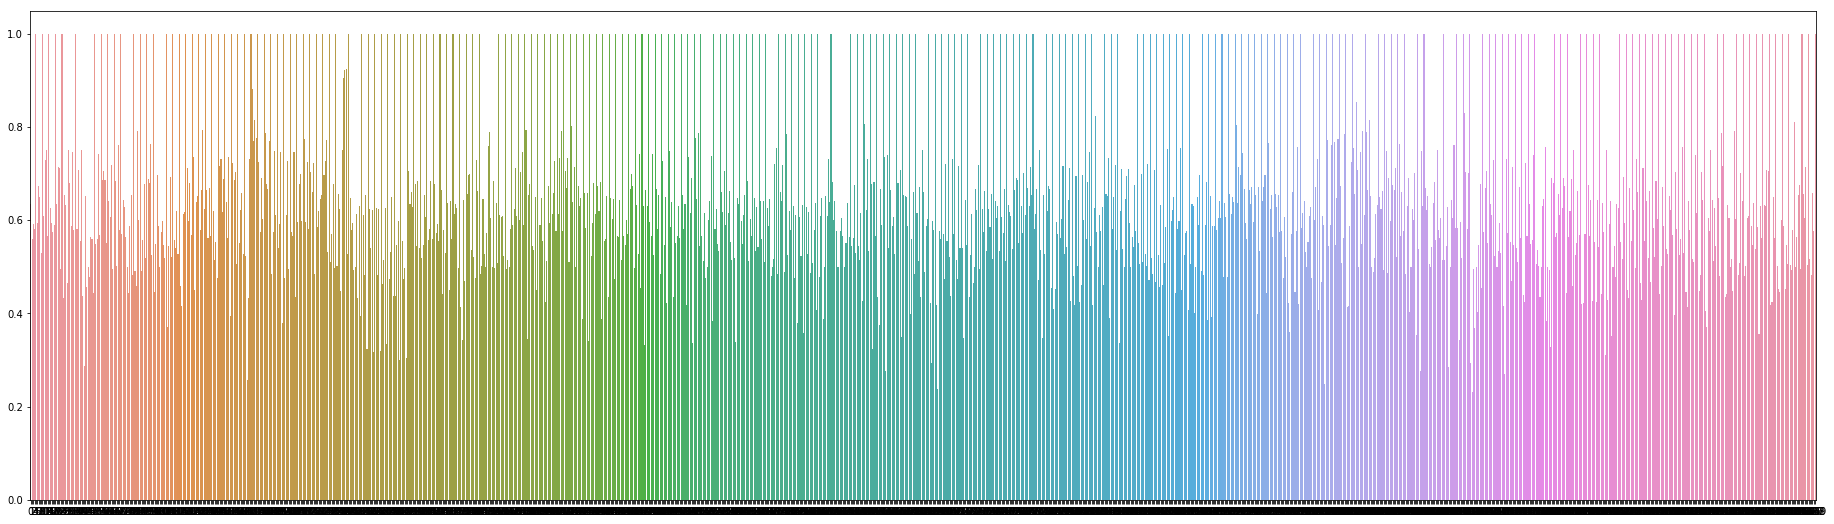

In [188]:
diff = (np.array(results['mri_max']) - np.array(results['mri_highpercnt']))/(np.array(results['mri_max'])-np.array(results['mri_min']))
plt.figure(figsize=(32,9))
sb.barplot(list(range(len(diff))), diff)

In [15]:
diff = (np.array(results['mri_max']) - np.array(results['mri_highpercnt']))/(np.array(results['mri_max'])-np.array(results)
pdiff = pd.DataFrame({'x': list(range(len(diff))), 'y':diff})
plt.figure(figsize=(32,9))
sb.barplot('x', 'y', data=pdiff)

FloatProgress(value=0.0, max=1370.0)

In [38]:
probs = hist/sum(hist)
import matplotlib.pyplot as plt
sum(probs[30:140])

0.9975897797955416

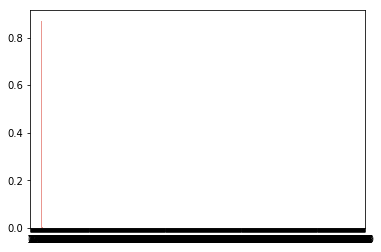

In [47]:
sb.barplot(y=probs, x=list(range(len(probs))))

In [48]:
len(hist)

1000

In [49]:
len(bins)

1001

In [98]:
bins_prob = [((bins[i], bins[i+1]), probs[i]) for i in range(len(bins)-1)]
# Order Probabilities descending
sort = sorted(bins_prob, key=lambda x:x[1], reverse=True)
def thresholding(sort, information_to_keep):
    current = 0
    current_sol = []
    for s in sort:
        current += s[1]
        current_sol.append(s)
        if current >= information_to_keep:
            break
    # Reordering bins
    current_sol = sorted(current_sol, key=lambda x: x[0][0])
    # Checking if bins are contiguous:
    for i in range(len(current_sol)-1):
        current_bin = current_sol[i]
        next_bin = current_sol[i+1]
        if current_bin[0][1] != next_bin[0][0]:
            print("Bin not contiguous: {} and {}".format(current_bin, next_bin))
    return current_sol
filtered = thresholding(sort, information_to_keep=0.9999)
len(filtered)
min_t = filtered[0][0][0]
max_t = filtered[-1][0][0]
min_t, max_t

(-251.154, 4419.876)

In [ ]:
filtered

In [107]:
voxel_range = [(f.min(), f.max()) for f in files if not (f.min() == 0 and f.max() == 4)]


In [112]:
import pandas as pd
minmax = pd.DataFrame(voxel_range).rename(columns={0:"min_value", 1:"max_value"})

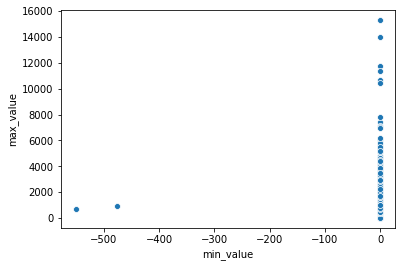

In [115]:
import seaborn as sb
sb.scatterplot(x="min_value", y="max_value", data=minmax)

In [116]:
above_thr = [f for f in files if f.max() > 9000]

In [125]:
count_nonzero = [np.bincount(f.flatten())[1:] for f in above_thr]

In [133]:
[sum(p[9000:]) for p in count_nonzero]

[17, 3, 27520, 214, 11371, 90]

In [137]:
testfile = above_thr[2]
np.where(testfile>9000)

(array([ 20,  21,  21, ..., 126, 126, 127]),
 array([113, 109, 113, ...,  96, 125, 125]),
 array([177, 169, 177, ..., 147, 110, 110]))

In [ ]:
plt.figure(figsize=(16,9));
plt.hist(testfile[126,:,:]);

In [ ]:
testslice = testfile[126,:,:]
plt.figure(figsize=(16,16));
plt.imshow(np.where(testslice, testslice, 0));
testfile[126, 130, 100]

In [ ]:
def rescale(x, xmin, xmax, a, b):
    ''' Rescales x from range (xmin, xmax) to an y in (a, b)'''
    return (a + (b-a)*(x-xmin)/(xmax-xmin))
rescale(0, 1, 98, 0, 1)

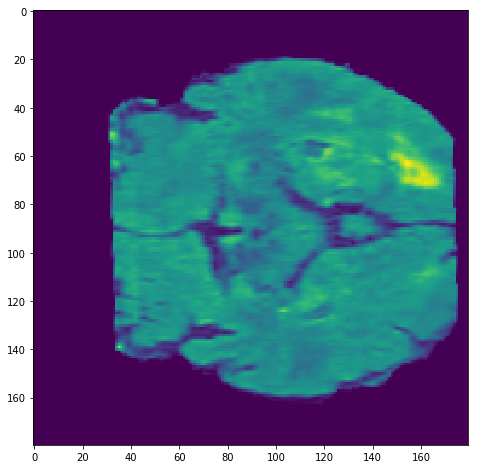

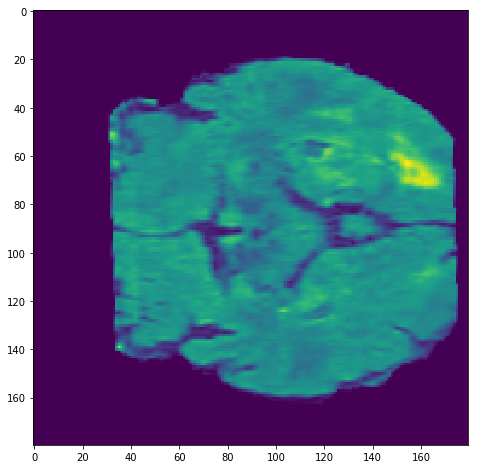

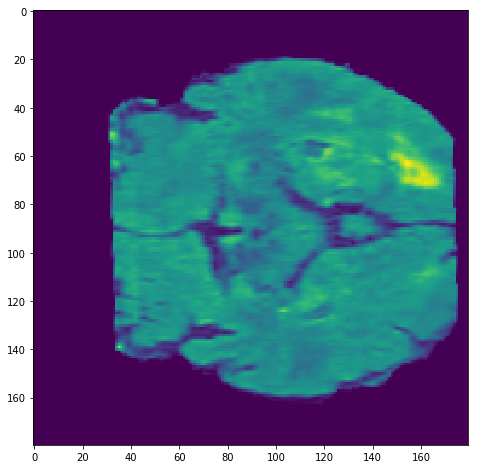

In [105]:
import matplotlib.pyplot as plt
testimg = results['mri_files'][0][50,:,:]
rescaled = rescale(testimg, results['mri_min'][0], results['mri_max'][0], 0, 1)
rescaled_dataset = rescale(testimg, minv, maxv, 0, 1)
plt.figure(figsize=(8,8));
plt.imshow(testimg);
plt.figure(figsize=(8,8));
plt.imshow(rescaled);
plt.figure(figsize=(8,8));
plt.imshow(rescaled_dataset);